In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
# !jupyter nbconvert --to script os.path.basename(__file__).ipynb
import warnings
warnings.filterwarnings("ignore")
import glob
import cv2
import csv
%matplotlib inline

In [6]:

#path_array: array of paths to folders from which to draw files
#extension: filetype to import
#returns array of filenames corresponding to same order of input folders

def importFiles(path_array,extension='*.txt'): 
    out=[]
    
    for folder in path_array:
        folder_files=[]
        for filename in glob.glob(os.path.join(folder, extension)):
            folder_files.append(filename)
        out.append(folder_files)
        
        
    #check that folders contain same number of files
    size=len(out[0])
    for x in out:
        if len(x)!=size:
            raise ValueError("Folders do not contain the same number of elements!")
    
    return tuple(out)


    
    
#from list of contours, returns array of contour areas.
def getContourAreas(contours):
    areas =[]
    
    for contour in contours:
        areas.append(cv2.contourArea(contour))
    return np.asarray(areas)

#reject contours with area that are more than m median standard 
#deviations from the median area.
#returns filtered_contours and rejected contours, and areas median
def rejectOutliers(contours,m=10,include_rejected=True,include_areas_median=True):
    filtered_contours=[]
    rejected_contours=[]
    areas=getContourAreas(contours)
    areas_median=np.median(areas)
    d=np.abs(areas-areas_median)
    mdev = np.median(d)
    
    for contour in contours:  
        
        c=abs(cv2.contourArea(contour)-areas_median)
        s=c/mdev if mdev else 0
        if s<m:
            filtered_contours.append(contour)
        else:
            rejected_contours.append(contour)
            
    
    return filtered_contours,rejected_contours,areas_median

#given a list of contours, fits number of points (tcell center of masses)
# that are within radius r of any point along contour.
#returns array of number of neighbors of each contour and 1d array of all T cells
#proximal to a dc.


#draw circle located at each t cells.  Note, size does not correspond to original 
# t cell size but is median t cell size.  
def generateImages(adj_tcells,im,r,color):
    for index,cell in adj_tcells.iterrows():
        cell=tuple([ int(x) for x in cell ])
        cv2.circle(im,cell,int(r),color)
# if needed, generates a 2d random distribution with same number of cells
# as original t cells.
def generateRandom(tcells_df,im):
    rand_x=np.random.uniform(low=0, high=im.shape[0],size=len(tcells_df))
    rand_y=np.random.uniform(low=0, high =im.shape[1],size=len(tcells_df))
    rand=np.vstack((rand_y,rand_x)).T
    return pd.DataFrame(rand)
#extract dataframe from file
def extract(file):
    df=pd.read_csv(file,sep="\t")
    #xyv_df=df[["X","Y","Volume (inch^3)"]]
    xyv_df=df[["X","Y","Volume (pixel^3)"]]

    return xyv_df
def reportResults(dc_df,normalized=True):
    if normalized:
        x=dc_df["Normalized_Counts"]
    else:
        x=dc_df["Counts"]
    with_clusters=(x>0).sum()
    nonzero=x[x>0]
    
    mean_colocalization=np.mean(nonzero)
    std_colocalization = np.std(nonzero)
#     print ()
#     print ("Number of DCs with clusters:",with_clusters)
#     print ("Average CoLocalization:",mean_colocalization)
#     #print ("Per Cell:",mean_colocalization/median)
#     print ("Number of DCs without clusters:",((x==0).sum()))
#     print ("Fraction of Dcs with clusters:", with_clusters*1.0/len(x)*100.0)

    return [with_clusters,mean_colocalization,std_colocalization,with_clusters*1.0/len(x)*100.0]

#from segmented, thresholded .tif file, extract contours using openCV


In [9]:
def calcPointsToContours(contours,tcells_df,r,scalar):
    r=-1*r
    #adjacent_neighbors=set()
    #n_neighbors=[]
    neigh=NearestNeighbors()
    dc_dict=dict()
    neigh.fit(tcells_df)
    for index,contour in zip(range(len(contours)),contours): 
        neighbors=[]
        #use center of mass to make generous circle.  THen refine with pointPolygonTest() function
        (x,y),radius = cv2.minEnclosingCircle(contour)
        rng=neigh.radius_neighbors((x,y),radius=radius*scalar,return_distance=False)[0]
        
        #use pointPolygonTest to filter those inside or on edge
        t_cands=tcells_df.iloc[rng]
        for index,t in t_cands.iterrows():
            retval=cv2.pointPolygonTest(contour, (t.X,t.Y), measureDist=True) 
            if retval>=r: #this includes retval==0 or <0 indicating edge or inside objects
                neighbors.append(index)
        
        #now get any t cells that are bounding these validated neighbors
        neighbors=set(neighbors)
        neigh_copy=neighbors.copy()
        for neighbor in neigh_copy:
            ptxy=tcells_df.iloc[neighbor]
            pt=(ptxy.X,ptxy.Y)
            getAdjacentCells(pt,-1.5*r,neigh,tcells_df,neighbors)
            
        dc_dict[index]={"contour":contour,"perimeter":cv2.arcLength(contour,True),"neighbors":list(neighbors)}
        #adjacent_neighbors.update(neighbors)
        
        
        #n_neighbors.append(len(neighbors))

                
    return dc_dict

def getAdjacentCells(pt,r,neigh,t_df,neighbors):
    #neighbors passed by reference
    
    rng=neigh.radius_neighbors(pt,radius=r,return_distance=False)[0]
    #base case
    
    if len(rng)>0:
        for neighbor in rng:
            if neighbor not in neighbors:
                neighbor_pt=t_df.iloc[neighbor]
                neighbors.add(neighbor)
                
                #update neighbors by passing by reference recursively
                getAdjacentCells((neighbor_pt.X,neighbor_pt.Y),r,neigh,t_df,neighbors)
            
        
def getContours(file):
    im=cv2.imread(file,-1)
    retval,bin_im=cv2.threshold(im,0,255,cv2.THRESH_BINARY)
    bin_8=np.uint8(bin_im)
    im2, contours, hierarchy=cv2.findContours(bin_8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #filtered_contours,rejected_contours,area=rejectOutliers(contours)
    #print (str(len(rejected_contours)/(len(contours))),"percent of contours were rejected due to debris")
    
    g=np.zeros(im2.shape,dtype='uint8')
    b=g
    rgb=cv2.merge((im2,g,b))
    cv2.drawContours(rgb,contours, -1, color=(0,0,255), thickness=1)
    #cv2.drawContours(rgb,rejected_contours, -1, color=(0,255,255), thickness=1)
   
    return contours,rgb
    
#remove t cells that have been counted for multiple Dcs.
#assign to closer DC
#Returns array with number of unique T cell neighbors and list of all adjacent T cells 
#if normalizeToPerimeter=True, normalize nubmer of T cells to DC perimeter
def eliminateRedundantTCells(dc_dict,tcells_df):
    pan,dc_df=getDCsWithMultipleT(dc_dict)
    mult=pan.loc[pan['Count'] >1]
    pruneRedundant(mult,dc_df,tcells_df)
    
    #make column with number of T cells neighboring dc
    num=[len(x) for x in dc_df["neighbors"]]
    dc_df["Counts"]=num
    dc_df["Normalized_Counts"]=np.divide(num,dc_df["perimeter"]+1)
    return dc_df,np.asarray(pan["Index"])
    

#take in df of tcells that are assigned to mulitple DCs and dataframe t cell positions
#return array for each dc of the number of neighbors
def pruneRedundant(mult,dc_df,tcells_df):
    for index, t in mult.iterrows():
        removeDistant(t,dc_df,tcells_df)
    
def removeDistant(t,dc_df,tcells_df):
    dist={}
    #For every dc that the tcell is near:
    for dc_index in t.DCs:
        #position of t cell
        
        pt=tcells_df.iloc[t.Index]
        #how far is this t cell to each dc contour
        retval=cv2.pointPolygonTest(dc_df.loc[dc_index].contour,(pt.X,pt.Y),measureDist=True)
        #add to dict
        dist[dc_index]=retval
    #sort dict by value so largest number (most inside is first)
    s = [k for k in sorted(dist, key=dist.get,reverse=True)]
    for far_cell in s[1:]:
        #remove this t cell cell from every far dc dataframe
        dc_df.loc[far_cell].neighbors.remove(t.Index)
        
#Returns two dataframes:  First: Rows are T cells shared by more than one DC, Column 1 is number of neighbors, Column2 is DC neighbors.
#Second: Rows are each DC, Column1 is surface area, Column 2 is neighbors

def getDCsWithMultipleT(dc_dict):
    c=pd.DataFrame(dc_dict).T
    val=c.neighbors.values #array of all adjacent t cells including redundant
    conc=np.concatenate(tuple(val)).astype(int)#flatten into single array
    un=np.unique(conc,return_counts =True)#return unique t cells with counts of each t cell (how many dcs its neighboring)
    stack=np.asmatrix(un)
    pan=pd.DataFrame(stack.T,columns=["Index","Count"]) #convert to a dataframe
    
    #Assign new column with a list of all DCs that each T cell neighbors
    pan["DCs"]= np.empty((len(pan), 0)).tolist()#init with empty list for each row
    
    #For every DC:
    for index,row in c.iterrows():
        #For every T cell it neighbors:
        for tcell in row.neighbors: 
            #Find that tcell by index and add this dc to its list of dc neighbors
            pan[pan['Index']==tcell].DCs.values[0].append(index)
    #get the t cells that are shared by multiple DCs
    
    return pan,c
    



In [10]:
#folder name
folder="Statistics from RATS and 3d object counter"

#enter filenames for different channels
dcxy01="Statistics for dcXY01-mask.csv"
txy01="Statistics for tcellXY01-mask.csv"

dcxy05="Statistics for dcxy05-mask.csv"
txy05="Statistics for tcellxy05-mask.csv"

# dcs="Statistics for Cluster2_XY01_00001_Overlay (red).csv"
# tcells="Statistics for Cluster2_XY01_00001_Overlay (green).csv"



#####MAIN######
Main_Folder="Stats_Complete_trial_copy/"
sub_folder_t="FINAL_tcell_data _Jerry"
sub_folder_dc="FINAL_dc_segmented_Jerry"
# Main_Folder="Stats_Complete_trial/"
# sub_folder_t="tcell_data"
# sub_folder_dc="dc_segmented"

tcell_path=Main_Folder+sub_folder_t
dc_path=Main_Folder+sub_folder_dc

#import tif image for dc which includes segmented and threhsolded image
dc_file= importFiles([dc_path],extension='*.tif')[0]

#import .txt file of t cell centers of mass
t_file=importFiles([tcell_path])[0]

#Default to write image with output.  If false,
# only calculates statistics.
writeImage=True

#if True, generate Random distribution to compare
compareToRandom=False

if len(dc_file)!=len(t_file):
    raise ValueError("Files sizes are not equal!")
    
    
with open(Main_Folder+"count_script_results.csv", 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Experiment ID","Number of DCs with clusters",
                      "Average Colocalization","Colocalization Standard Deviation",
                      "Fraction of Dcs with clusters"])
    
    index=0
    for dc,t in zip(dc_file,t_file):
        if index<1:
            index+=1
            print ("Extracting File...")
            tcells_df=extract(t)
            tcells_v=np.median(tcells_df[["Volume (pixel^3)"]] )
            del tcells_df["Volume (pixel^3)"]
            contours,im=getContours(dc)

            if compareToRandom:
                tcells_df=generateRandom(tcells_df,im)

            cell_radius=(tcells_v**.5)/3.14
            counting_radius=cell_radius*3
            scalar=3 #how generous to be with DC bounding circle

            print ("Calculating Points to Contours...")
            #x,adjacent_neighbors=calcPointsToContours(contours,tcells_df,counting_radius,scalar)
            dc_dict=calcPointsToContours(contours,tcells_df,counting_radius,scalar)

            print ("Eliminating Redundant T Cells")
            dc_df,adjacent_neighbors=eliminateRedundantTCells(dc_dict,tcells_df)


            experiment=dc.split('Fused')[0].split('/')[-1]

            ###UNCOMMENT####
            wr.writerow([experiment]+reportResults(dc_df,normalized=False))


            adj_tcells=tcells_df.iloc[adjacent_neighbors]
            rej_tcells=tcells_df.iloc[np.setdiff1d(range(len(tcells_df)), adjacent_neighbors, assume_unique=True)]

            filename=Main_Folder+"FINAL_output_images/"+experiment+".tif"
            generateImages(adj_tcells,im,cell_radius,(0,255,0))
            generateImages(rej_tcells,im,cell_radius,(255,0,0))
            print ("Image saved as: ", filename)
            print ()
            cv2.imwrite(filename,im)
            

        
#         print ()
#         print ("Image saved as: ", filename)
#         print ("#########")
    
print ("Finished!")
    
    

    

Extracting File...
Calculating Points to Contours...
Eliminating Redundant T Cells
Image saved as:  Stats_Complete_trial_copy/FINAL_output_images/Cluster_1_XY01_.tif

Extracting File...
Calculating Points to Contours...


KeyboardInterrupt: 

           X          Y
0  57.156363  97.370521
1  79.129416  21.769454


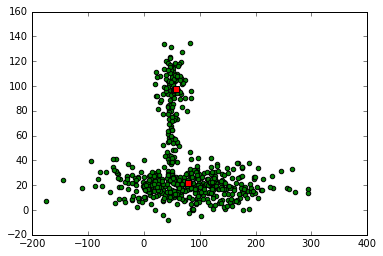

In [8]:
np.random.seed(10)
rand_x1=np.random.normal(loc=50,scale=14,size=100)
rand_y1=np.random.normal(loc=100,scale=14,size=100)
rand_x2=np.random.normal(loc=80,scale=80,size=400)
rand_y2=np.random.normal(loc=20,scale=10,size=400)
rand_x3=np.random.normal(loc=50,scale=5,size=50)
rand_y3=np.random.normal(loc=50,scale=20,size=50)

dcx1=np.random.normal(loc=50,scale=10,size=1)
dcy1=np.random.normal(loc=100,scale=10,size=1)
dcx2=np.random.normal(loc=80,scale=5,size=1)
dcy2=np.random.normal(loc=20,scale=5,size=1)

rand1=np.vstack((rand_x1,rand_y1)).T
rand2=np.vstack((rand_x2,rand_y2)).T
rand3=np.vstack((rand_x3,rand_y3)).T
data=np.concatenate((rand1,rand2,rand3),axis=0)
df= pd.DataFrame(data,columns=["X","Y"])

dc1=np.vstack((dcx1,dcy1)).T
dc2=np.vstack((dcx2,dcy2)).T
dc_data=np.concatenate((dc1,dc2),axis=0)
dc_df= pd.DataFrame(dc_data,columns=["X","Y"])
print (dc_df.head())

plt.scatter(df.X,df.Y,c="g")
plt.scatter(dc_df.X,dc_df.Y,c="r",marker='s',s=40)
plt.show()

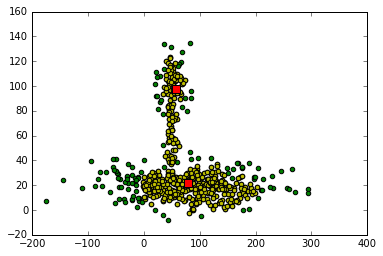

In [10]:
n=NearestNeighbors()
n.fit(df)
r=6
neighbors=set()

for index, dc in dc_df.iterrows():
    pt=(dc.X,dc.Y)
    getAdjacentCells(pt,r,n,df,neighbors)
    #neighbors.update(n.radius_neighbors((dc.X,dc.Y),radius=r,return_distance=False)[0])
    #neighbors=np.concatenate((neighbors,rng))
    
    
    


sel_cells=df.iloc[list(neighbors)]


plt.scatter(df.X,df.Y,c="g")

plt.scatter(sel_cells.X,sel_cells.Y,c="y")
plt.scatter(dc_df.X,dc_df.Y,c="r",marker='s',s=50)
plt.show()